In [24]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OMP_WAIT_POLICY"] = "PASSIVE"

import torch
torch.set_num_threads(1)

import colbert.warp.setup

from colbert.warp.config import WARPRunConfig
from colbert.warp.searcher import WARPSearcher
from colbert.warp.data.queries import WARPQueries

from colbert.warp.openvino_model import (
    XTROpenVinoConfig,
)

from colbert.warp.onnx_model import (
    XTROnnxConfig,
)

from colbert.warp.onnx_model import (
    XTROnnxConfig,
    XTROnnxQuantization
)

from colbert.utils.tracker import ExecutionTracker

In [25]:
optim = XTROnnxConfig(quantization=XTROnnxQuantization.PREPROCESS)

config = WARPRunConfig(
    nranks=4,
    dataset="lotte",
    collection="lifestyle",
    type_="search",
    datasplit="test",
    nbits=4,
    k=100,
    optim=optim
)
searcher = WARPSearcher(config)
queries = WARPQueries(config)

[Aug 28, 09:21:32] #> Loading collection...
0M 
#> Loading XTR ONNX model from '/lfs/1/scheerer/models/xtr.v=16.batch=1.PREPROCESS.onnx' (418.78MB)


/future/u/scheerer/miniconda3/envs/colbert/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


[Aug 28, 09:21:34] #> Loading buckets...
[Aug 28, 09:21:34] #> Loading codec...
[Aug 28, 09:21:35] #> Loading repacked residuals...
[Aug 28, 09:21:36] #> Loading the queries from /lfs/1/scheerer/datasets/lotte/lotte/lifestyle/test/questions.search.tsv ...
[Aug 28, 09:21:36] #> Got 661 queries. All QIDs are unique.



In [26]:
tracker = ExecutionTracker(name="XTR/WARP", steps=["Query Encoding", "Candidate Generation", "top-k Precompute",
                                                   "Decompression", "Lookup", "Build Matrix"])
ranking = searcher.search_all(queries, k=100, batched=False, tracker=tracker)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 661/661 [00:45<00:00, 14.51it/s]


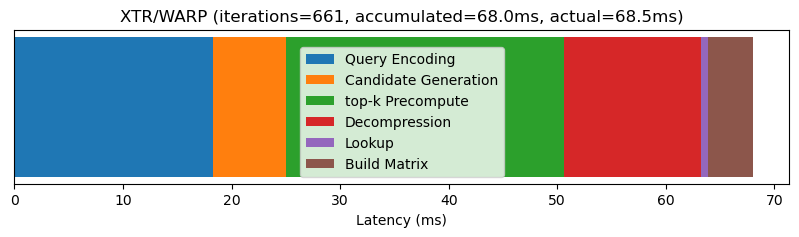

In [27]:
tracker.display()

In [31]:
ranking.evaluate(queries.qrels, k=5)

{'provenance': {'query_type': 'search', 'dataset': 'lifestyle'},
 'metrics': {'Success@5': 0.8229954614220878}}

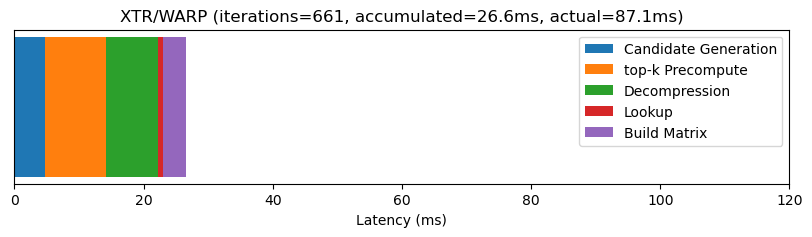

In [4]:
tracker.display(["Candidate Generation", "top-k Precompute", "Decompression", "Lookup", "Build Matrix"], bound=120)

In [5]:
from colbert.searcher import Searcher
from colbert.modeling.colbert import ColBERT
from tqdm import tqdm

ColBERT.try_load_torch_extensions(use_gpu=False)

cb_searcher = Searcher(index=config.index_name, config=config.colbert(), index_root=config.index_root, warp_engine=False)
cb_tracker = ExecutionTracker(name="ColBERTv2/PLAID", steps=["Query Encoding", "Candidate Generation", "Filtering", 
                                                             "Decompress Residuals", "Scoring", "Sorting"])

for qid, qtext in tqdm(queries):
    cb_tracker.next_iteration()
    cb_searcher.search(qtext, k=5, tracker=cb_tracker)
    cb_tracker.end_iteration()

[Aug 12, 06:46:45] Loading segmented_maxsim_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...
[Aug 12, 06:46:46] #> Loading collection...
0M 


/future/u/scheerer/miniconda3/envs/colbert/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


[Aug 12, 06:46:49] #> Loading codec...
[Aug 12, 06:46:49] #> Loading IVF...
[Aug 12, 06:46:49] #> Loading doclens...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 274.54it/s]

[Aug 12, 06:46:49] #> Loading codes and residuals...



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.05it/s]

[Aug 12, 06:46:50] Loading filter_pids_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...


[Aug 12, 06:46:51] Loading decompress_residuals_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 661/661 [02:20<00:00,  4.71it/s]


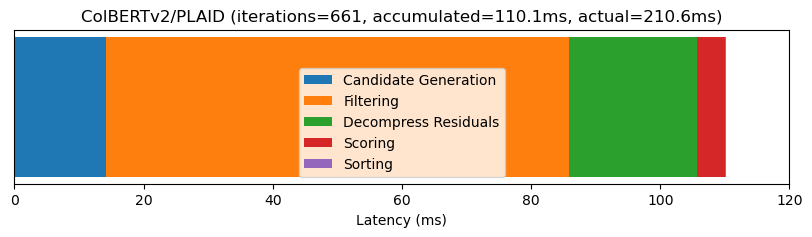

In [6]:
cb_tracker.display(["Candidate Generation", "Filtering", "Decompress Residuals", "Scoring", "Sorting"], bound=120)

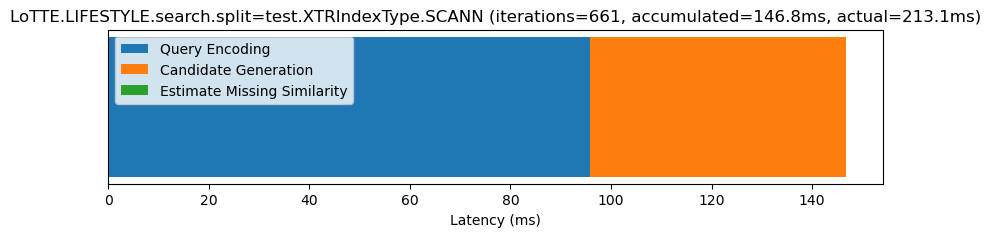

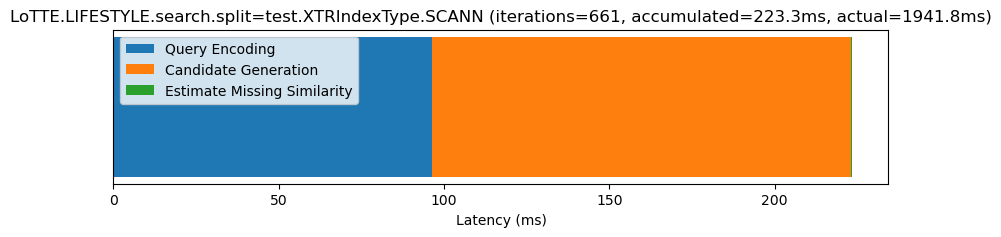

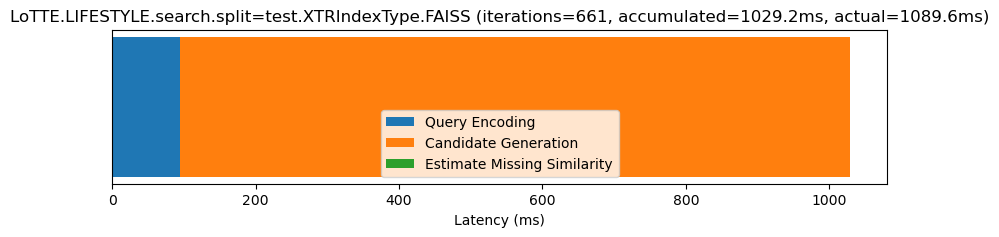

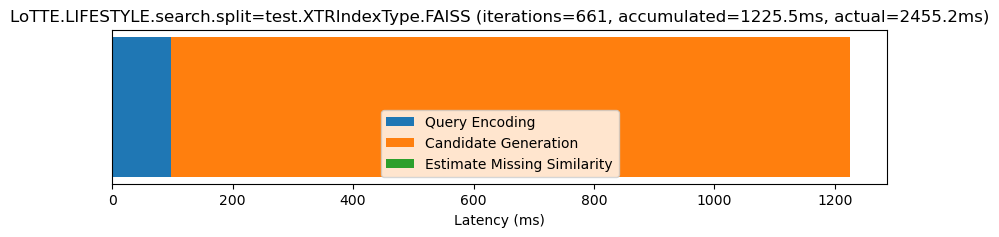

In [11]:
import json
with open("xtr-eval/results.json", "r") as file:
    results = json.load(file)
    for entry in results:
        tracker = ExecutionTracker.from_dict(entry["tracker"])
        tracker.display(["Query Encoding", "Candidate Generation", "Estimate Missing Similarity"])